In [1]:
# !pip install opencv-contrib-python --upgrade

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img

In [2]:
model_best = tf.keras.models.load_model('../esha/R_CNN')

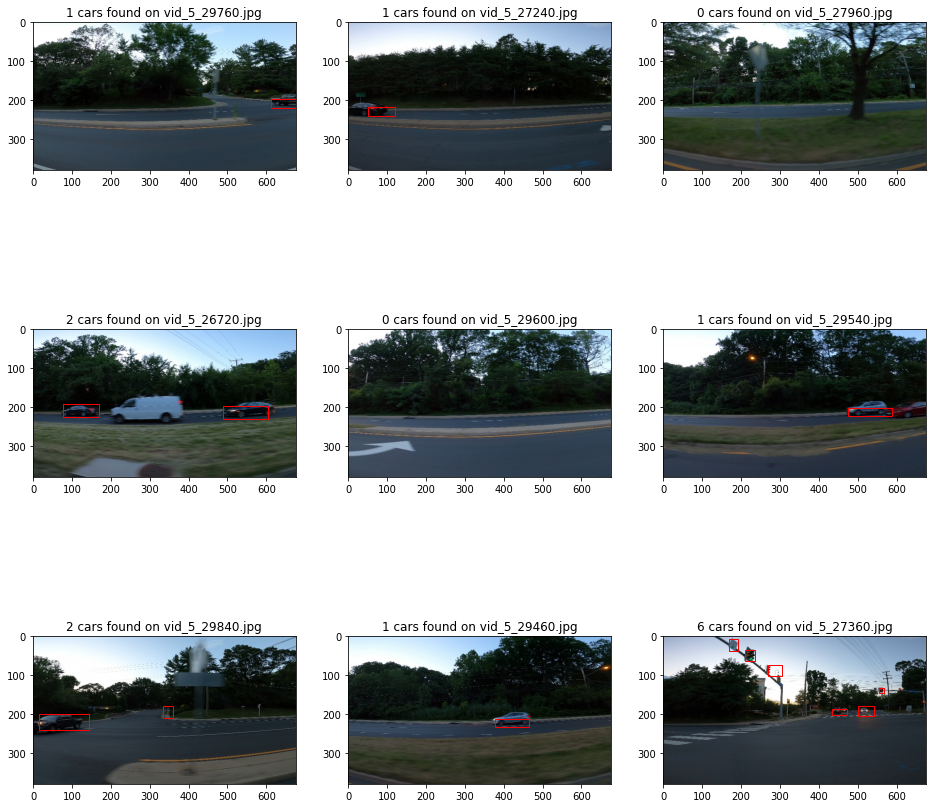

In [4]:
import random

target_size = (224, 224)
test_files = tf.io.gfile.glob('../data/testing_images/*.jpg')

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
max_proposed_boxes = 2000

samples = random.sample(test_files,9)

fig, axes = plt.subplots(3,3,figsize=(16,16))
axes = axes.flatten()

for i in range(len(samples)):
    filename = samples[i].split('\\')[-1]
    counter = 0
    
    img = load_img(samples[i])
    normalized_img_array = img_to_array(img)

    ss.setBaseImage(img_to_array(img))
    ss.switchToSelectiveSearchFast()
    rects = ss.process()

    car_boxes = []
    probas = []
    cars = 0

    for (x, y, w, h) in rects:

        if counter <= max_proposed_boxes:
            counter += 1
            filename_box = filename
            proposed_box = [x, y, x + w, y + h]

            image_array = normalized_img_array[proposed_box[1]:proposed_box[3],proposed_box[0]:proposed_box[2]]
            image_array = cv2.resize(image_array,target_size)

            predicted = model_best.predict(image_array.reshape(1,224,224,3), verbose=0)

            if np.argmax(predicted) == 1 and predicted[0][1] >= 0.8:
                car_boxes.append([y, x, y + h, x + w])
                probas.append(predicted[0][1])

    img_w, img_h = 676, 380
    pic = plt.imread(samples[i])
    
    if len(probas) > 0:
        selected_indices = tf.image.non_max_suppression(car_boxes, probas, 100, iou_threshold=0.0)
        selected_boxes = tf.gather(car_boxes, selected_indices)
        for j in selected_boxes:
            ymin, xmin, ymax, xmax = j[0], j[1], j[2], j[3]
            rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
            axes[i].add_patch(rect)
            cars += 1
            
    title = str(cars) + ' cars found on ' + filename
    axes[i].set_title(title)
    axes[i].imshow(pic)